In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
import seaborn as sns
import matplotlib as mpl
from ipywidgets import interactive


In [4]:
from platform import python_version
print('Running on pyMC3 v{}'.format(pm.__version__))
print('Running Python version v{}'.format(python_version()))

Running on pyMC3 v3.7
Running Python version v3.7.4


## Overdose Model

We assume the following:  

Underlying log rate follows Normal distribution.
$$z_{t} \sim N(\mu, \sigma^{2})$$  

Overdose rate is deterministic variable that exponentiates log rate.
$$\lambda_{t}^{OD} = \exp(z_{t})$$

Overdoses follows Poission distribution.
$$O_{t} \sim Poi(\lambda_{t}^{OD}N)$$
  
We start from the most basic model.
Let's assume a single t, a certain month. 


Our interest is the overdoses. The number of overdoses is not easy to obtain in the real world so we estimate.
We start from the simplest case where t=1.
Set N=10000, $z_{t}$=-0.5. Then we generate a single observation.
we obtain 1000 samples of parameters and posterior predictive samples and plot them with the observation.

In [39]:
N = 10000; z_t= -4
o_t = np.random.poisson(lam=(np.exp(z_t)*N))
print('O_t is :', o_t)
print('lambda is :', np.exp(z_t))

O_t is : 182
lambda is : 0.01831563888873418


We set for our prior parameter $\mu$ and $\sigma$ -4 and 1 respectively. 
This model is not hierachical model yet. 

In [27]:
with pm.Model() as model:
    z_t =pm.Normal('z_t', mu=-4, sigma=1)
    x=pm.Poisson('O_t', mu=tt.exp(z_t)*N, observed=o_t)

In [28]:
with model:
    trace = pm.sample(1000)
    ppc = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [z_t]
100%|██████████| 2000/2000 [00:02<00:00, 974.85it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c20cefbd0>,
      dtype=object)

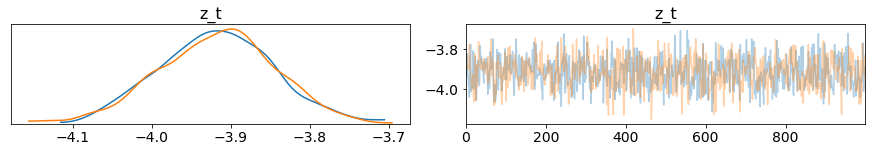

In [29]:
pm.traceplot(trace)

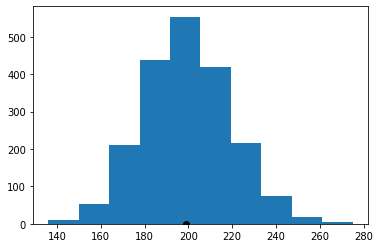

In [38]:
plt.hist(ppc['O_t'])
plt.plot(o_t,0, 'ko')

Now we think of overdose per a year where t= 1,2,3, ..., 12.
We need a vector of z_t to generate a vector of overdoses. 

We set for our prior parameter $\mu$ and $\sigma$ -4 and 1 respectively. 

In [54]:
import random
random.seed(1)
z_t = np.random.normal(loc=-4, scale=1, size = 12)
o_t = np.random.poisson(lam=(np.exp(z_t)*N))
print('Vector z_t: ', z_t)
print('Vector o_t: ', o_t)


Vector z_t:  [-5.4206548  -3.55845589 -4.67532952 -1.97792256 -3.55330192 -3.6521718
 -4.25518649 -2.83195436 -4.68140202 -3.55635852 -2.52796818 -3.2831038 ]
Vector o_t:  [  31  298   80 1379  288  252  145  582   92  267  753  370]


Now we have our vector of observations.
Before fitting a model to the data, let's assume that $p(\mu)$ and $p(\sigma^2)$ is noninformative, say uniform.
$$p(\mu) = U(-10, 10)$$  
$$p(\sigma) = U(-3, 3)$$  
Let's fit the model to the data o_t.

In [60]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower = -10, upper= 0)
    sigma = pm.Uniform('sigma', lower = 3, upper= 3)
    z_t =pm.Normal('z_t',mu=mu, sigma=sigma, shape = (12,))
    
    x = pm.Poisson('o_t', mu=tt.exp(z_t)*N, shape=(12,), observed=o_t)

In [61]:
with model:
    trace =pm.sample(1000)
    ppc = pm.sample_posterior_predictive(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [z_t, sigma, mu]
Sampling 2 chains:   0%|          | 0/3000 [00:00<?, ?draws/s]/Users/hyeongcheolpark/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling 2 chains:   0%|          | 0/3000 [00:02<?, ?draws/s]
Bad initial energy, check any log probabilities that are inf or -inf, nan or very small:
sigma_interval__   NaN


ParallelSamplingError: Bad initial energy

/Users/hyeongcheolpark/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [34]:
def plot_data_timeseries(ys, xs=None, xlabel="Month", ylabel="Overdoses", new_plot=True, color="#E14A33", label=None):
    
    '''
    brief intro: plot 95 and IQR
    parameters:
    -----
    ys: sample size by time numpy array 
    xs: x axis as time
    xlabel: string
    ylabel: string
    new_plot: boolean
        plotting to a new figure or not
    color: str
    label: str
    return
    -----
    
    
    '''
    if xs is None:
        xs = np.arange(1,ys.shape[1]+1)
    
    if new_plot: plt.figure;
        # if we wanna make a new plot, then by using plt.figure function,
        # we create a new plot figure
        
    lc, liqr, m, uiqr, uc = np.percentile(ys, [2.5,25,50,75,97.5], axis=0);
    # now it's time to use the (already) existing plot figure
    plt.fill_between(xs, lc, uc,alpha=0.2 ,color=color);
    plt.fill_between(xs, liqr, uiqr, color=color, alpha=0.2);
    plt.plot(xs,m, color= color, label = label);
    plt.xlabel(xlabel);plt.ylabel(ylabel);

# Ambulance Call-outs

$n_{A}$: sample size   
$x_{A}$: the total number who confirmed they did call an ambulance  
$p_{A}$: probability of a person call an ambulance   

$$x_{A} \sim Bin(n_{A},p_{A})$$

We assume $n_{A}=100$ 

Note that 